### CAPSTONE PROJECT 1 - PREDICTING THE HEALTH OF STREET TREES IN NEW YORK CITY

The documents describing this project can be found in the same repository.
The dataset used in this project has been downloaded locally and imported. It can be found at the following address:
https://data.cityofnewyork.us/Environment/2015-Street-Tree-Census-Tree-Data/uvpi-gqnh

DATA WRANGLING AND CLEAN UP

In [1]:
# Import relevant modules
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import seed
import scipy.stats as scs

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.metrics import auc,precision_score,recall_score, f1_score, roc_curve


from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours

from sklearn.preprocessing import LabelBinarizer

from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE,SelectKBest,chi2,RFECV



In [2]:
# Import dataset
df=pd.read_csv('2015_Street_Tree_Census_Tree_Data.csv')
print('Dataset imported')

Dataset imported


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 683788 entries, 0 to 683787
Data columns (total 45 columns):
tree_id             683788 non-null int64
block_id            683788 non-null int64
created_at          683788 non-null object
tree_dbh            683788 non-null int64
stump_diam          683788 non-null int64
curb_loc            683788 non-null object
status              683788 non-null object
health              652172 non-null object
spc_latin           652169 non-null object
spc_common          652169 non-null object
steward             652173 non-null object
guards              652172 non-null object
sidewalk            652172 non-null object
user_type           683788 non-null object
problems            652124 non-null object
root_stone          683788 non-null object
root_grate          683788 non-null object
root_other          683788 non-null object
trunk_wire          683788 non-null object
trnk_light          683788 non-null object
trnk_other          683788 non-nu

In [4]:
df.head()

,tree_id,block_id,created_at,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,spc_common,...,boro_ct,state,latitude,longitude,x_sp,y_sp,council district,census tract,bin,bbl
0,180683,348711,08/27/2015,3,0,OnCurb,Alive,Fair,Acer rubrum,red maple,...,"4,073,900",New York,40.723092,-73.844215,"1,027,431.148","202,756.7687",29.0,739,4052307.0,4.022210e+09
1,200540,315986,09/03/2015,21,0,OnCurb,Alive,Fair,Quercus palustris,pin oak,...,"4,097,300",New York,40.794111,-73.818679,"1,034,455.701","228,644.8374",19.0,973,4101931.0,4.044750e+09
2,204026,218365,09/05/2015,3,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,...,"3,044,900",New York,40.717581,-73.936608,"1,001,822.831","200,716.8913",34.0,449,3338310.0,3.028870e+09
3,204337,217969,09/05/2015,10,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,...,"3,044,900",New York,40.713537,-73.934456,"1,002,420.358","199,244.2531",34.0,449,3338342.0,3.029250e+09
4,189565,223043,08/30/2015,21,0,OnCurb,Alive,Good,Tilia americana,American linden,...,"3,016,500",New York,40.666778,-73.975979,"990,913.775","182,202.426",39.0,165,3025654.0,3.010850e+09


In [5]:
# Remove columns that aren't used or contains redundant information
drop_list=['tree_id','block_id','spc_latin','address','postcode','zip_city','community board','cncldist',
        'st_assem','st_senate','nta','boro_ct','state','x_sp','y_sp','council district','census tract',
        'bin','bbl']
df.drop(drop_list,axis=1,inplace=True)
df.head()

,created_at,tree_dbh,stump_diam,curb_loc,status,health,spc_common,steward,guards,sidewalk,...,trnk_light,trnk_other,brch_light,brch_shoe,brch_other,borocode,borough,nta_name,latitude,longitude
0,08/27/2015,3,0,OnCurb,Alive,Fair,red maple,None,None,NoDamage,...,No,No,No,No,No,4,Queens,Forest Hills,40.723092,-73.844215
1,09/03/2015,21,0,OnCurb,Alive,Fair,pin oak,None,None,Damage,...,No,No,No,No,No,4,Queens,Whitestone,40.794111,-73.818679
2,09/05/2015,3,0,OnCurb,Alive,Good,honeylocust,1or2,None,Damage,...,No,No,No,No,No,3,Brooklyn,East Williamsburg,40.717581,-73.936608
3,09/05/2015,10,0,OnCurb,Alive,Good,honeylocust,None,None,Damage,...,No,No,No,No,No,3,Brooklyn,East Williamsburg,40.713537,-73.934456
4,08/30/2015,21,0,OnCurb,Alive,Good,American linden,None,None,Damage,...,No,No,No,No,No,3,Brooklyn,Park Slope-Gowanus,40.666778,-73.975979


In [6]:
# Check 'health' column, which is the target variable for the model. Remove rows that don't have an entry. 
# Check a couple of columns of interest after removal.
df.dropna(subset=['health'],axis=0,inplace=True)
df.status.describe()

count     652172
unique         1
top        Alive
freq      652172
Name: status, dtype: object

In [7]:
df['stump_diam'].describe()

count    652172.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: stump_diam, dtype: float64

In [8]:
# The above results shows that after removing the rows that don't have an 'health' entry, 
# the 'status' and 'stump diameter' variables have a unique value, so they can be removed.
df.drop(['status','stump_diam'],axis=1,inplace=True)

In [9]:
# Rename columns, drop rows with missing values if their number is very low compared to total number of entries.
df.rename(columns={'tree_dbh': 'tree_diam','spc_common':'species'},inplace=True)
#df.info()

In [10]:
df.dropna(subset=['species','guards','sidewalk','problems'],axis=0,inplace=True)

In [11]:
df.problems.describe()

count     652118
unique       232
top         None
freq      426276
Name: problems, dtype: object

In [12]:
# Analyze the only numerical feature, apart form langitude, latitude and borocode
df.tree_diam.describe()

count    652118.000000
mean         11.709684
std           8.634257
min           0.000000
25%           5.000000
50%          10.000000
75%          16.000000
max         425.000000
Name: tree_diam, dtype: float64

Text(3.799999999999997, 0.5, 'Tree diameter (inches)')

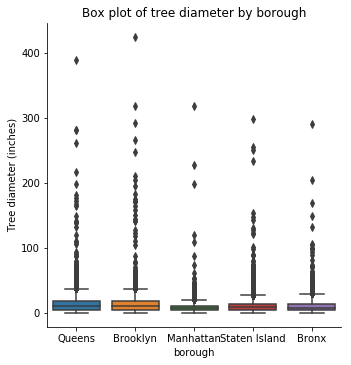

In [13]:
sns.catplot(x="borough", y="tree_diam", kind="box", data=df)
plt.title('Box plot of tree diameter by borough')
plt.ylabel('Tree diameter (inches)')

In [14]:
df.groupby('borough')['tree_diam'].max()

borough
Bronx            291
Brooklyn         425
Manhattan        318
Queens           389
Staten Island    298
Name: tree_diam, dtype: int64

In [15]:
df.groupby('species')['tree_diam'].max().sort_values(ascending=False)

species
swamp white oak          425
tulip-poplar             389
London planetree         318
pin oak                  318
Callery pear             298
cherry                   291
littleleaf linden        266
mulberry                 217
Japanese zelkova         210
Norway maple             204
willow oak               199
black locust             177
crimson king maple       172
honeylocust              169
silver maple             168
green ash                159
red maple                154
Siberian elm             149
Sophora                  141
sweetgum                 128
Chinese elm              118
ginkgo                   106
eastern redcedar          99
Schumard's oak            91
Atlantic white cedar      89
northern red oak          76
American elm              65
black oak                 64
crab apple                64
eastern cottonwood        64
                        ... 
European alder            29
kousa dogwood             28
serviceberry              28
paper 

In [16]:
df.groupby('species')['tree_diam'].median().sort_values(ascending=False)[:20]

species
London planetree      22.0
silver maple          21.0
pin oak               17.0
eastern cottonwood    16.0
horse chestnut        15.0
pignut hickory        15.0
weeping willow        14.0
Norway maple          14.0
sycamore maple        14.0
ash                   13.0
catalpa               13.0
green ash             13.0
white ash             12.0
mulberry              11.0
white pine            11.0
sugar maple           11.0
maple                 11.0
tree of heaven        11.0
black locust          11.0
willow oak            10.0
Name: tree_diam, dtype: float64

In [17]:
df.groupby('species')['tree_diam'].mean().sort_values(ascending=False)[:20]

species
London planetree      21.560900
silver maple          21.017927
eastern cottonwood    17.061594
pin oak               16.867053
weeping willow        15.797872
pignut hickory        15.393939
sycamore maple        14.767118
Norway maple          14.330516
catalpa               14.284936
mulberry              14.219533
horse chestnut        14.015511
ash                   13.684553
green ash             13.566338
white ash             12.672614
tree of heaven        12.664021
white pine            12.569307
willow oak            12.279209
black locust          12.192825
American elm          11.953229
sassafras             11.807018
Name: tree_diam, dtype: float64

In [18]:
# Diameter values above 100 are suspicious. They are reported across all boroughs and for more than 1 species.
# It is considered a typo or wrong entry. 
# A threshold of 90 is used to filter, the entries above this value are removed, since they are a small percentage
# of the data.
df_tree=df[df['tree_diam']<=90]

In [19]:
#df_tree[df_tree.duplicated(['species','tree_diam','created_at'])]
df_tree[df_tree.duplicated()]

,created_at,tree_diam,curb_loc,health,species,steward,guards,sidewalk,user_type,problems,...,trnk_light,trnk_other,brch_light,brch_shoe,brch_other,borocode,borough,nta_name,latitude,longitude
62722,09/16/2015,28,OnCurb,Good,London planetree,None,None,Damage,TreesCount Staff,Stones,...,No,No,No,No,No,3,Brooklyn,Midwood,40.615966,-73.956801
184923,10/26/2015,3,OnCurb,Good,sawtooth oak,1or2,None,NoDamage,Volunteer,None,...,No,No,No,No,No,4,Queens,Woodside,40.748463,-73.910383
271605,11/28/2015,9,OnCurb,Good,Sophora,None,None,NoDamage,TreesCount Staff,None,...,No,No,No,No,No,3,Brooklyn,DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill,40.693128,-73.986285
273114,11/28/2015,9,OnCurb,Good,Sophora,None,None,NoDamage,TreesCount Staff,None,...,No,No,No,No,No,3,Brooklyn,DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill,40.693094,-73.985292
276682,12/04/2015,9,OnCurb,Good,red maple,None,None,NoDamage,NYC Parks Staff,None,...,No,No,No,No,No,5,Staten Island,New Springville-Bloomfield-Travis,40.610977,-74.156861
278174,12/04/2015,12,OnCurb,Good,Callery pear,None,None,NoDamage,NYC Parks Staff,None,...,No,No,No,No,No,5,Staten Island,New Springville-Bloomfield-Travis,40.610977,-74.156861
278356,12/04/2015,9,OnCurb,Good,red maple,None,None,NoDamage,NYC Parks Staff,None,...,No,No,No,No,No,5,Staten Island,New Springville-Bloomfield-Travis,40.610977,-74.156861
278413,12/04/2015,6,OnCurb,Good,red maple,None,None,NoDamage,NYC Parks Staff,None,...,No,No,No,No,No,5,Staten Island,New Springville-Bloomfield-Travis,40.610977,-74.156861
278459,12/04/2015,9,OnCurb,Good,pin oak,None,None,NoDamage,NYC Parks Staff,None,...,No,No,No,No,No,5,Staten Island,New Springville-Bloomfield-Travis,40.610977,-74.156861
278500,12/04/2015,9,OnCurb,Good,red maple,None,None,NoDamage,NYC Parks Staff,None,...,No,No,No,No,No,5,Staten Island,New Springville-Bloomfield-Travis,40.610977,-74.156861


In [20]:
df_tree.drop_duplicates()
df_tree.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 652044 entries, 0 to 683787
Data columns (total 24 columns):
created_at    652044 non-null object
tree_diam     652044 non-null int64
curb_loc      652044 non-null object
health        652044 non-null object
species       652044 non-null object
steward       652044 non-null object
guards        652044 non-null object
sidewalk      652044 non-null object
user_type     652044 non-null object
problems      652044 non-null object
root_stone    652044 non-null object
root_grate    652044 non-null object
root_other    652044 non-null object
trunk_wire    652044 non-null object
trnk_light    652044 non-null object
trnk_other    652044 non-null object
brch_light    652044 non-null object
brch_shoe     652044 non-null object
brch_other    652044 non-null object
borocode      652044 non-null int64
borough       652044 non-null object
nta_name      652044 non-null object
latitude      652044 non-null float64
longitude     652044 non-null float64
d

In [21]:
df_tree.reset_index(drop=True,inplace=True)
df_tree.tail()

,created_at,tree_diam,curb_loc,health,species,steward,guards,sidewalk,user_type,problems,...,trnk_light,trnk_other,brch_light,brch_shoe,brch_other,borocode,borough,nta_name,latitude,longitude
652039,08/18/2015,25,OnCurb,Good,pin oak,None,None,Damage,Volunteer,None,...,No,No,No,No,No,3,Brooklyn,North Side-South Side,40.713211,-73.954944
652040,08/29/2015,7,OnCurb,Good,Kentucky yellowwood,1or2,None,NoDamage,Volunteer,None,...,No,No,No,No,No,4,Queens,Forest Hills,40.715194,-73.856650
652041,08/22/2015,12,OnCurb,Good,red maple,None,None,Damage,Volunteer,None,...,No,No,No,No,No,5,Staten Island,Westerleigh,40.620762,-74.136517
652042,08/29/2015,9,OnCurb,Good,red maple,None,None,NoDamage,TreesCount Staff,None,...,No,No,No,No,No,2,Bronx,Mount Hope,40.850828,-73.903115
652043,09/03/2015,23,OnCurb,Fair,red maple,None,None,NoDamage,TreesCount Staff,None,...,No,No,No,No,No,4,Queens,Fresh Meadows-Utopia,40.732165,-73.787526


EXPLORE DATA

Plot trees health and count vs location and other features (for example position, steward).

In [22]:
# Set color palette for plots as 'colorblind'
bcol=sns.color_palette('colorblind').as_hex()
sns.set_palette("colorblind")

Text(0, 0.5, 'Count')

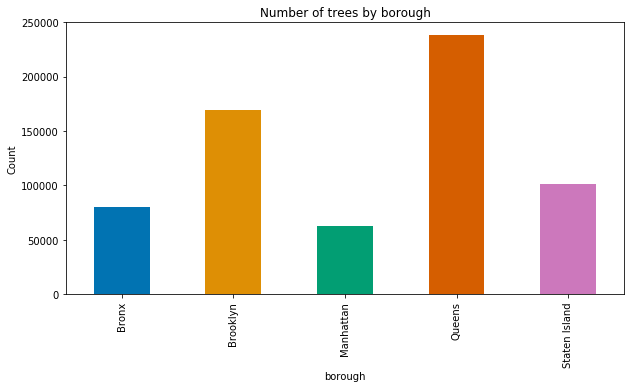

In [23]:
df_tree.groupby('borough')['tree_diam'].count().plot(kind='bar',color=bcol,figsize=(10,5))
plt.title('Number of trees by borough')
plt.ylabel('Count')

The first plot already shows something interesting: the highest number of tress isn't in Manhattan, where Central Park is located, but in Queens! Manhattan has the lowest number of trees.

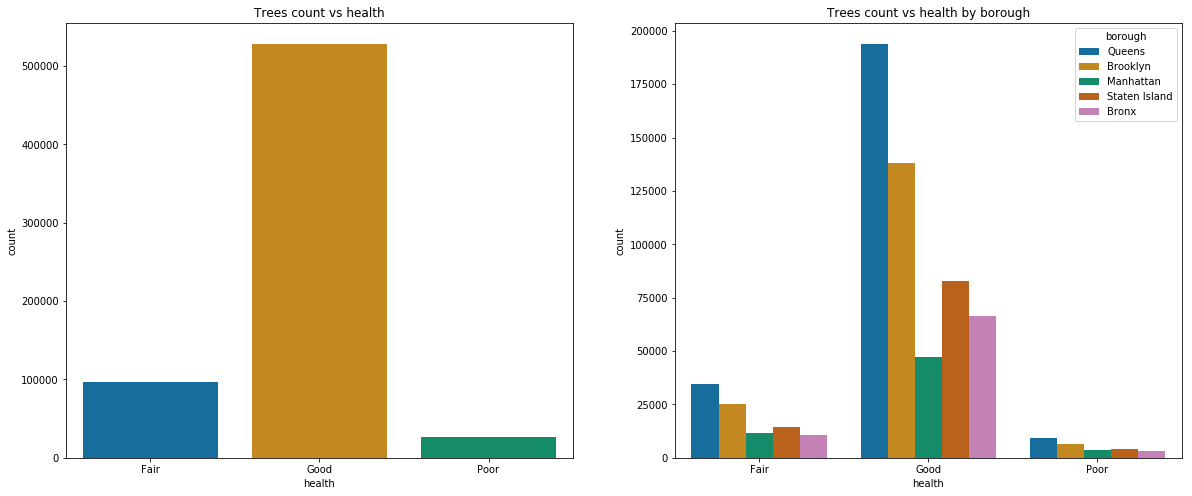

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(20,8))
sns.catplot(x="health", kind="count", data=df_tree,ax=axes[0])
axes[0].set_title('Trees count vs health')
sns.catplot(x="health", kind="count", hue='borough',data=df_tree,ax=axes[1])
axes[1].set_title('Trees count vs health by borough')
plt.close(2)
plt.close(3)

The data set is skewed towards the "good" health, so it will probably need to be balanced when creating a predictive model.
This is true if both looking at the overall trees' count and by borough. It is also confirmed by the fact that the order of borough by trees count is the same, reagrdless of health.  

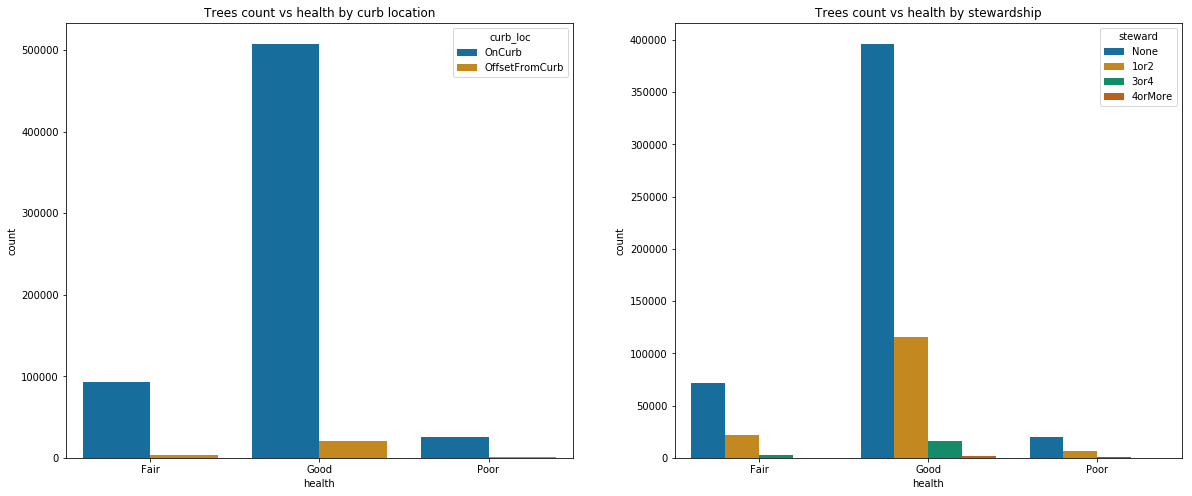

In [25]:
fig1, axes1 = plt.subplots(1, 2, figsize=(20,8))
sns.catplot(x="health", kind="count", hue='curb_loc', data=df_tree,ax=axes1[0])
axes1[0].set_title('Trees count vs health by curb location')
sns.catplot(x="health", kind="count", hue='steward', data=df_tree,ax=axes1[1])
axes1[1].set_title('Trees count vs health by stewardship')
plt.close(3)
plt.close(2)

Text(0.5, 1.0, 'Trees count vs user type and health')

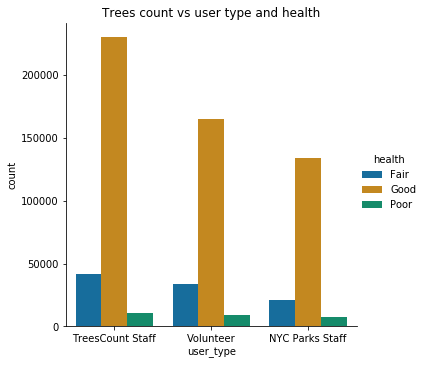

In [26]:
sns.catplot(x="user_type", kind="count", hue='health', data=df_tree)
plt.title('Trees count vs user type and health')

The fact that trees have been attended to or not, and by whom, volunteers or staff, doesn't affect the health status. The trends are confirmed. 

Plot trees' diameter vs location, health.

In [27]:
# Plot diameter vs borough and health after grouping and applying custom function
bor_group=df_tree.groupby('borough')
bor_list=list(bor_group.groups.keys())
health_group=df_tree.groupby('health')
health_list=list(health_group.groups.keys())

def avg_diam(group):
    diam=[group['tree_diam'].mean().round(1) for k,group in group]
    return(diam)

Text(0, 0.5, 'Diameter (inches)')

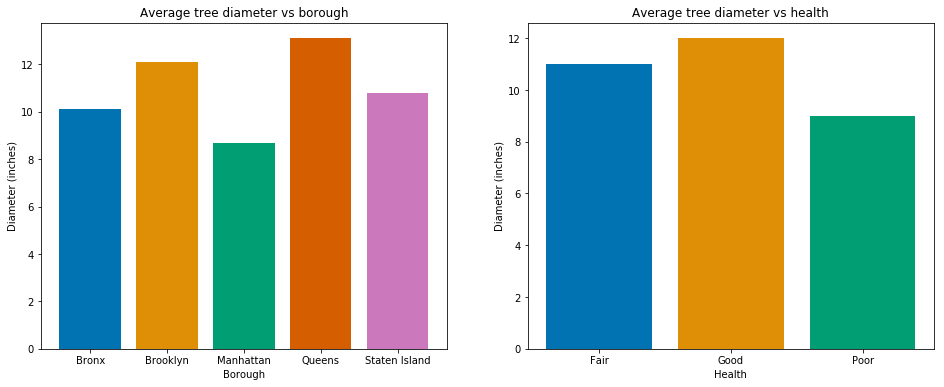

In [28]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.bar(range(len(bor_group.groups)),avg_diam(bor_group),tick_label=bor_list,color=bcol)
plt.title('Average tree diameter vs borough')
plt.xlabel('Borough')
plt.ylabel('Diameter (inches)')
plt.subplot(1,2,2)
plt.bar(range(len(health_group.groups)),avg_diam(health_group),tick_label=health_list,color=bcol)
plt.title('Average tree diameter vs health')
plt.xlabel('Health')
plt.ylabel('Diameter (inches)')

The trees diameter plots show a couple of interesting results. The diameter follows the order of the borough by number of individuals: where there are more trees, their diameter is also bigger. Furthermore, there's a possible correlation between the diameter and the health: helthiest trees seem to have bigger diameters. The latter finding suggest the diameter is a variable to use when building the model.

A different view at trees' diameter and number vs borough and health.

In [29]:
df_hbd=df_tree[['health','borough','tree_diam']].groupby(['health','borough'])
df_hbd.groups.keys()

dict_keys([('Fair', 'Bronx'), ('Fair', 'Brooklyn'), ('Fair', 'Manhattan'), ('Fair', 'Queens'), ('Fair', 'Staten Island'), ('Good', 'Bronx'), ('Good', 'Brooklyn'), ('Good', 'Manhattan'), ('Good', 'Queens'), ('Good', 'Staten Island'), ('Poor', 'Bronx'), ('Poor', 'Brooklyn'), ('Poor', 'Manhattan'), ('Poor', 'Queens'), ('Poor', 'Staten Island')])

In [30]:
hl=[]
bl=[]
cl=[]
dl=[]
for name,group in df_hbd: 
    print(name,len(group.index), group['tree_diam'].mean().round(1))
    hl.append(name[0])
    bl.append(name[1])
    cl.append(len(group.index))
    dl.append(group['tree_diam'].mean().round(1))

('Fair', 'Bronx') 10885 9.2
('Fair', 'Brooklyn') 25067 11.3
('Fair', 'Manhattan') 11457 8.1
('Fair', 'Queens') 34540 12.6
('Fair', 'Staten Island') 14533 10.2
('Good', 'Bronx') 66592 10.3
('Good', 'Brooklyn') 138186 12.5
('Good', 'Manhattan') 47351 9.0
('Good', 'Queens') 193987 13.3
('Good', 'Staten Island') 82635 11.0
('Poor', 'Bronx') 3094 7.6
('Poor', 'Brooklyn') 6457 8.7
('Poor', 'Manhattan') 3609 6.8
('Poor', 'Queens') 9415 10.7
('Poor', 'Staten Island') 4236 8.7


In [31]:
d={'health': hl, 'borough': bl, 'trees_num': cl, 'avg_diam':dl}
nd=pd.DataFrame(d)
nd

,health,borough,trees_num,avg_diam
0,Fair,Bronx,10885,9.2
1,Fair,Brooklyn,25067,11.3
2,Fair,Manhattan,11457,8.1
3,Fair,Queens,34540,12.6
4,Fair,Staten Island,14533,10.2
5,Good,Bronx,66592,10.3
6,Good,Brooklyn,138186,12.5
7,Good,Manhattan,47351,9.0
8,Good,Queens,193987,13.3
9,Good,Staten Island,82635,11.0


In [32]:
nd['trees_norm']=(nd['trees_num']-nd['trees_num'].min())/(nd['trees_num'].max()-nd['trees_num'].min())
nd['diam_norm']=(nd['avg_diam']-nd['avg_diam'].min())/(nd['avg_diam'].max()-nd['avg_diam'].min())
nd

,health,borough,trees_num,avg_diam,trees_norm,diam_norm
0,Fair,Bronx,10885,9.2,0.040813,0.369231
1,Fair,Brooklyn,25067,11.3,0.115106,0.692308
2,Fair,Manhattan,11457,8.1,0.043810,0.200000
3,Fair,Queens,34540,12.6,0.164731,0.892308
4,Fair,Staten Island,14533,10.2,0.059924,0.523077
5,Good,Bronx,66592,10.3,0.332637,0.538462
6,Good,Brooklyn,138186,12.5,0.707684,0.876923
7,Good,Manhattan,47351,9.0,0.231842,0.338462
8,Good,Queens,193987,13.3,1.000000,1.000000
9,Good,Staten Island,82635,11.0,0.416678,0.646154


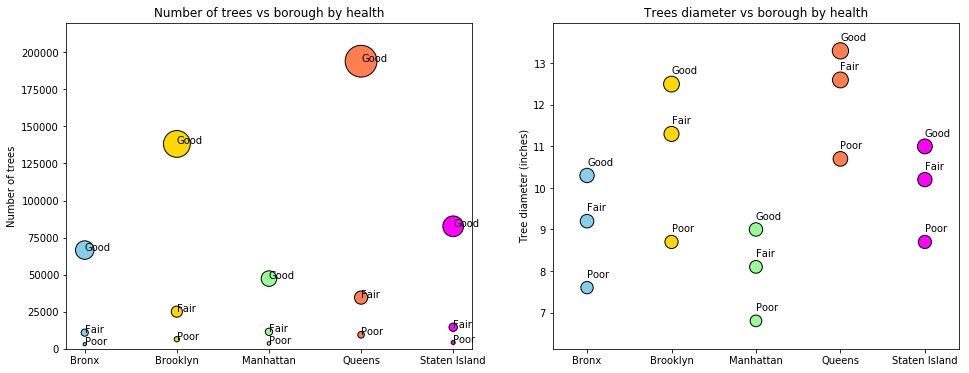

In [33]:
colors=nd.borough.map({'Bronx': 'skyblue', 'Brooklyn': 'gold','Manhattan':'palegreen',
                       'Queens':'coral','Staten Island':'magenta'})
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.scatter(nd.borough,nd['trees_num'], s = nd['trees_norm']*1000+10, c=colors, linewidths=1,edgecolors='k') 
plt.title('Number of trees vs borough by health')
plt.ylabel('Number of trees')
plt.ylim([0,220000])
for i in nd.index:
    plt.annotate(nd.health[i],xy=(nd.borough[i],nd['trees_num'][i]+0.2))
plt.subplot(1,2,2)
plt.scatter(nd.borough,nd['avg_diam'],  s = nd['avg_diam']*20, c=colors, linewidths=1, edgecolors='k') 
plt.margins(0.1)
plt.title('Trees diameter vs borough by health')
plt.ylabel('Tree diameter (inches)')
for i in nd.index:
    plt.annotate(nd.health[i],xy=(nd.borough[i],nd['avg_diam'][i]+0.25))    

Another look at the diameter vs health and borough reveals that the same diameter is an indication of a different health, depending on where the tree is located. This suggest that it may be appropriate to apply the model separately to the different boroughs.

Analyses of species.

In [34]:
# number of unique species
df_tree['species'].unique().size

132

In [35]:
# most common species
df_tree['species'].value_counts()[:20]

London planetree     87000
honeylocust          64252
Callery pear         58916
pin oak              53172
Norway maple         34184
littleleaf linden    29738
cherry               29269
Japanese zelkova     29254
ginkgo               21017
Sophora              19337
red maple            17245
green ash            16248
American linden      13530
silver maple         12271
sweetgum             10655
northern red oak      8400
silver linden         7995
American elm          7975
maple                 7080
purple-leaf plum      6877
Name: species, dtype: int64

In [36]:
# least common species
df_tree['species'].value_counts()[-20:]

red pine            106
pignut hickory       99
bigtooth aspen       94
eastern hemlock      88
Atlas cedar          87
Douglas-fir          85
southern red oak     83
quaking aspen        83
Ohio buckeye         75
Himalayan cedar      72
boxelder             64
Shantung maple       59
smoketree            58
European alder       47
American larch       46
black pine           37
pitch pine           33
Osage-orange         29
Scots pine           25
Virginia pine        10
Name: species, dtype: int64

In [37]:
# Create separate dataframes for the different boroughs. Visualize most common species.
#bor_list=list(df_tree.borough.unique())
bor_list

['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']

In [38]:
def bordf(df,name):
    df_bor=df[df.borough==name]
    df_bor.reset_index(drop=True,inplace=True)
    return(df_bor)
df_queens=bordf(df_tree,'Queens')  
df_brook=bordf(df_tree,'Brooklyn')  
df_manh=bordf(df_tree,'Manhattan') 
df_state=bordf(df_tree,'Staten Island') 
df_bronx=bordf(df_tree,'Bronx') 

Text(0.5, 0, 'Count')

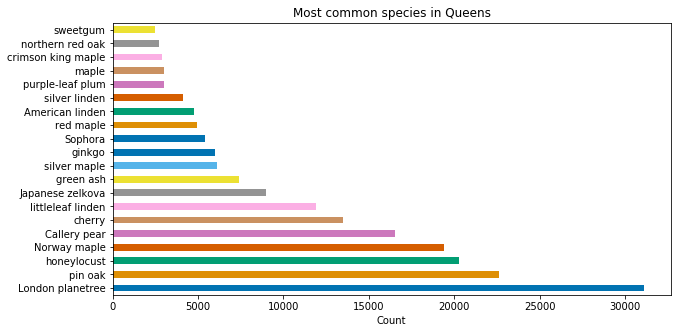

In [39]:
df_queens.species.value_counts()[:20].plot(kind='barh',figsize=(10,5))
plt.title('Most common species in Queens')
plt.xlabel('Count')

Text(0.5, 0, 'Count')

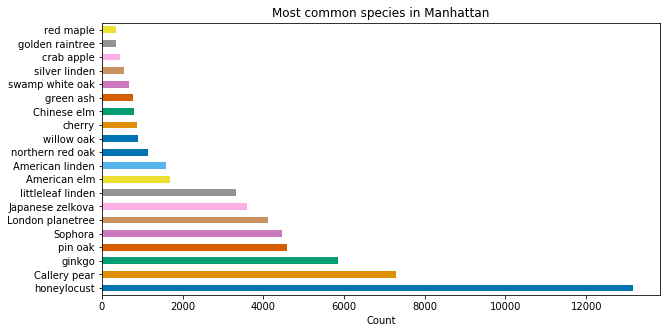

In [40]:
df_manh.species.value_counts()[:20].plot(kind='barh',figsize=(10,5))
plt.title('Most common species in Manhattan')
plt.xlabel('Count')

Although the number of trees in Queens and Manhanttan is quite different, they have some species in common. Maybe the difference is due to a different area. A quick check confirmed that Queen's land areas is approximately 5 times Manhattan's.

TEXT TO NUMERICAL CONVERSION

In [41]:
# Create a function to use for conversion of text data to numerical.
def label_enc(series):
    
    series=series.astype('category')
    new_series=series.cat.codes
    return(new_series)

# list of features to be converted
enc_list=['curb_loc', 'health','steward',
       'guards', 'sidewalk', 'user_type','root_stone',
       'root_grate', 'root_other', 'trunk_wire', 'trnk_light', 'trnk_other',
       'brch_light', 'brch_shoe', 'brch_other']

# Apply function to entire dataframe and boroughs separately

def encoder(df,enc_list):
    
    '''label encoding of list of columns of a dataframe'''
    
    df_text=df[enc_list].copy()
    df_text_enc=df_text.transform(label_enc)
    df_text_noenc=df.copy()
    df_text_noenc.drop(enc_list,axis=1,inplace=True)
    df_enc=pd.concat([df_text_noenc,df_text_enc], axis=1)
    return df_enc    

df_tree_enc=encoder(df_tree,enc_list)

queens_enc=encoder(df_queens,enc_list)  
brook_enc=encoder(df_brook,enc_list)   
manh_enc=encoder(df_manh,enc_list)   
state_enc=encoder(df_state,enc_list)  
bronx_enc=encoder(df_bronx,enc_list)  

df_tree_enc.head()

,created_at,tree_diam,species,problems,borocode,borough,nta_name,latitude,longitude,curb_loc,...,user_type,root_stone,root_grate,root_other,trunk_wire,trnk_light,trnk_other,brch_light,brch_shoe,brch_other
0,08/27/2015,3,red maple,None,4,Queens,Forest Hills,40.723092,-73.844215,1,...,1,0,0,0,0,0,0,0,0,0
1,09/03/2015,21,pin oak,Stones,4,Queens,Whitestone,40.794111,-73.818679,1,...,1,1,0,0,0,0,0,0,0,0
2,09/05/2015,3,honeylocust,None,3,Brooklyn,East Williamsburg,40.717581,-73.936608,1,...,2,0,0,0,0,0,0,0,0,0
3,09/05/2015,10,honeylocust,Stones,3,Brooklyn,East Williamsburg,40.713537,-73.934456,1,...,2,1,0,0,0,0,0,0,0,0
4,08/30/2015,21,American linden,Stones,3,Brooklyn,Park Slope-Gowanus,40.666778,-73.975979,1,...,2,1,0,0,0,0,0,0,0,0


STATISTICAL ANALYSIS

Diameter mean value:  11.691272368122396
Diameter standard deviation:  8.425066737626212


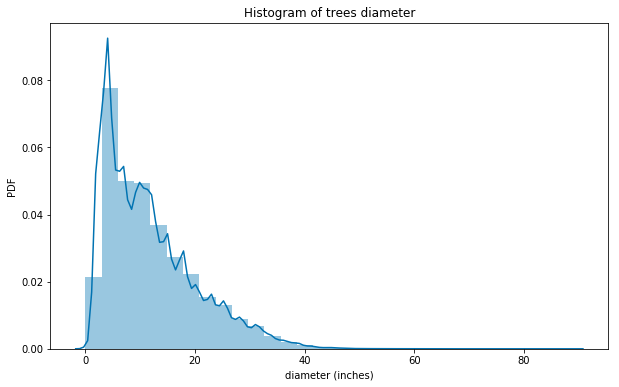

In [42]:
# Check distribution of trees' diameter
diam_data=df_tree_enc['tree_diam'].values
diam_mean=np.mean(diam_data)
diam_std=np.std(diam_data)
print('Diameter mean value: ',diam_mean)
print('Diameter standard deviation: ',diam_std)

# Plot histogram
_ = plt.figure(figsize=(10,6))
_ = plt.title('Histogram of trees diameter')
_ = plt.xlabel('diameter (inches)')
_ = plt.ylabel('PDF')
_ = sns.distplot(diam_data, bins=30)

The trees' diameter is clearly not normally distributed. For confirmation, its empirical cumulative density function can be compared to the one from a normal distribution having the same mean and standard deviation. Moreover, the distribution looks similar to a gamma distribution. 

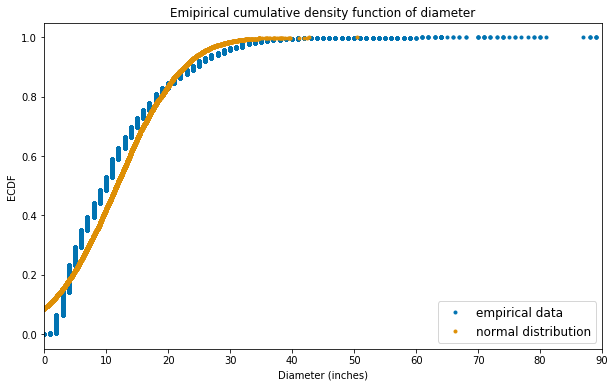

In [43]:
# Creat normal distribution with same mean and std
diam_norm=np.random.normal(diam_mean,diam_std,size=10000)

# Define function to calculate empirical cumulative density function
# and apply it to empirical and normal data of trees' diameter
def ecdf(data):
    n=len(data)
    x=np.sort(data)
    y = np.arange(1, n+1) / n
    return(x,y)   

emp_x, emp_y=ecdf(diam_data)
norm_x,norm_y=ecdf(diam_norm)

# Plot ECDFs
_ = plt.figure(figsize=(10,6))
_ = plt.plot(emp_x, emp_y, marker='.',linestyle='none',label='empirical data')
_ = plt.plot(norm_x, norm_y, marker='.',linestyle='none',label='normal distribution')
_ = plt.xlim([0,90])
_ = plt.title('Emipirical cumulative density function of diameter')
_ = plt.xlabel('Diameter (inches)')
_ = plt.ylabel('ECDF')
_ = plt.legend(fontsize='large',loc='lower right')

The ecdf plot confirms that the distribution isn't normal. Next, the same function is plotted for the five boroughs separately, to check if the distribution is the same regardless of location.

c:\users\silvia\appdata\local\programs\python\python36\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


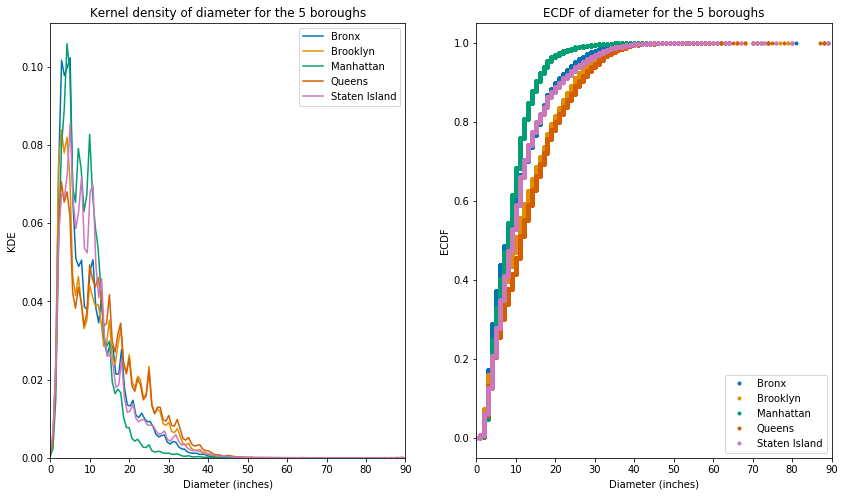

In [44]:
data_manh=df_manh['tree_diam'].values
data_queens=df_queens['tree_diam'].values
data_brook=df_brook['tree_diam'].values
data_bronx=df_bronx['tree_diam'].values
data_state=df_state['tree_diam'].values

data_list=[data_bronx,data_brook,data_manh,data_queens,data_state]

_ = plt.figure(figsize=(14,8))

for i,data in enumerate(data_list):
    x,y=ecdf(data)
    
    _ = plt.subplot(1,2,1)
    _ = sns.kdeplot(data,shade=False,label=bor_list[i],bw=0.5)
    _ = plt.xlim([0,90])
    _ = plt.title('Kernel density of diameter for the 5 boroughs')
    _ = plt.xlabel('Diameter (inches)')
    _ = plt.ylabel('KDE')
    _ = plt.legend(fontsize='medium')    
    
    _ = plt.subplot(1,2,2)
    _ = plt.plot(x,y,marker='.',linestyle='none',label=bor_list[i])
    _ = plt.xlim([0,90])
    _ = plt.title('ECDF of diameter for the 5 boroughs')
    _ = plt.xlabel('Diameter (inches)')
    _ = plt.ylabel('ECDF')
    _ = plt.legend(fontsize='medium')  


The five boroughs seem to have similar distributions, but different values of the parameters. It looks like Queens and Brooklyn and Staten Island and Bronx have a similar value of the parameters. Manhattan instead differs from all the other boroughs. This can be confirmed by permutation sampling.

In [45]:
# Define function to generate permutation sample from 2 data sets
def perm_sample(data1,data2):
    data=np.concatenate((data1,data2))
    perm_data = np.random.permutation(data)
    perm_sam1 = perm_data[:len(data1)]
    perm_sam2 = perm_data[len(data1):]
    return(perm_sam1, perm_sam2)

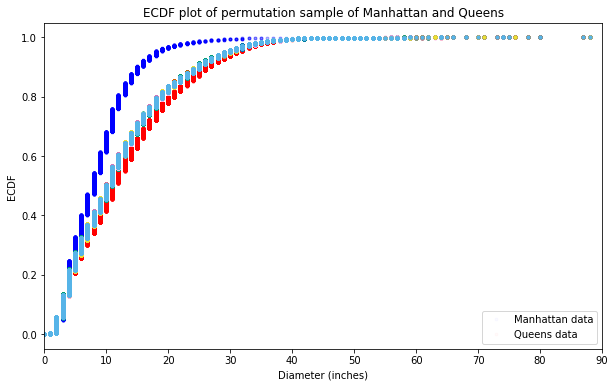

In [46]:
# Apply function to data from Manhattan and Queens, which seems to have different distributions
#ECDF of empirical data
xm,ym=ecdf(data_manh)
xq,yq=ecdf(data_queens)


_ = plt.figure(figsize=(10,6))
_ = plt.xlim([0,90])
_ = plt.title('ECDF plot of permutation sample of Manhattan and Queens')
_ = plt.xlabel('Diameter (inches)')
_ = plt.ylabel('ECDF')

_ = plt.plot(xm,ym, marker='.', linestyle='none', label='Manhattan data', color='b',
                 alpha=0.02)
_ = plt.plot(xq,yq, marker='.', linestyle='none', label='Queens data', color='r',
                 alpha=0.02)
_ = plt.legend() 

for _ in range(50):
    sam1,sam2=perm_sample(data_manh,data_queens)
    x1, y1 = ecdf(sam1)
    x2, y2 = ecdf(sam2)
    # Plot ECDFs of permutation sample
    _ = plt.plot(x1, y1, marker='.', linestyle='none')
    _ = plt.plot(x2, y2, marker='.', linestyle='none')

   

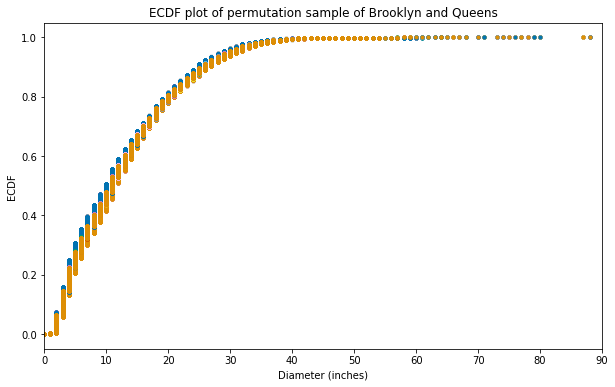

In [47]:
# Apply function to data from Brooklyn and Queens, which seems to have similar distributions

#ECDF of empirical data
xb,yb=ecdf(data_brook)


_ = plt.figure(figsize=(10,6))
_ = plt.xlim([0,90])
_ = plt.title('ECDF plot of permutation sample of Brooklyn and Queens')
_ = plt.xlabel('Diameter (inches)')
_ = plt.ylabel('ECDF')

_ = plt.plot(xb,yb, marker='.', linestyle='none', label='Brooklyn data', 
                 alpha=0.02)
_ = plt.plot(xq,yq, marker='.', linestyle='none', label='Queens data', 
                 alpha=0.02)


for _ in range(50):
    sam1,sam2=perm_sample(data_brook,data_queens)
    x1, y1 = ecdf(sam1)
    x2, y2 = ecdf(sam2)
    # Plot ECDFs of permutation sample
    _ = plt.plot(x1, y1, marker='.', linestyle='none')
    _ = plt.plot(x2, y2, marker='.', linestyle='none')

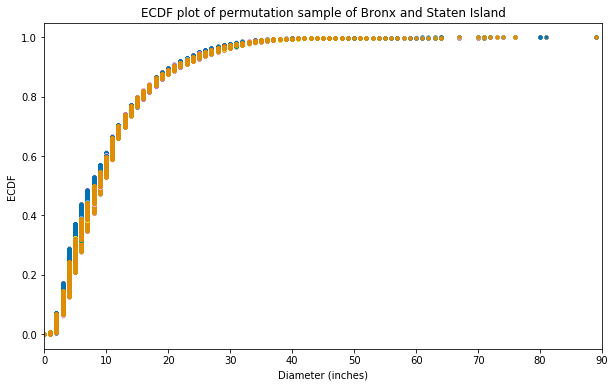

In [48]:
# Apply function to data from Bronx and Staten Island, which seems to have similar distributions

#ECDF of empirical data
xbr,ybr=ecdf(data_bronx)
xst,yst=ecdf(data_state)


_ = plt.figure(figsize=(10,6))
_ = plt.xlim([0,90])
_ = plt.title('ECDF plot of permutation sample of Bronx and Staten Island')
_ = plt.xlabel('Diameter (inches)')
_ = plt.ylabel('ECDF')

_ = plt.plot(xbr,ybr, marker='.', linestyle='none', label='Bronx data', 
                 alpha=0.02)
_ = plt.plot(xst,yst, marker='.', linestyle='none', label='Staten Island data', 
                 alpha=0.02)

for _ in range(50):
    sam1,sam2=perm_sample(data_bronx,data_state)
    x1, y1 = ecdf(sam1)
    x2, y2 = ecdf(sam2)
    # Plot ECDFs of permutation sample
    _ = plt.plot(x1, y1, marker='.', linestyle='none')
    _ = plt.plot(x2, y2, marker='.', linestyle='none')

After gaining some insight on the distribution of the only continuous variable (tree's diameter), the other variables that can be included in the model are looked at. These are categorical variables previously encoded. A chi-squared test of independence is run to verify the relation between each categorical variable and the health (dependent) variable. A significance level of 0.05 is chosen. For each test, if the p-value is less than the significance level, the corresponding variable is kept to be possibly used in the model.

In [49]:
# Set significance level. 
alpha=0.05

#Define function that creates contingency table (using crosstab from Pandas) 
# and runs chi squared test of indepence
# The arguments are the dataframe columns
def chi_squared_col(col1,col2):
    chi_sq,p_val,dof,exp=scs.chi2_contingency(pd.crosstab(index=col2,columns=col1))
    return(chi_sq,p_val)   

# Define function to apply chi-squared test between the dependent variable (health)
# and the other categorical variables, one at a time
# The first argument is the dependent variable (series)
# The second argument is a dataframe of the independent variables
def chi_squared(dvar,df_x,alpha):
    chi_list=[]
    p_list=[]
    for name in df_x.columns:
        chi_list.append(chi_squared_col(dvar,df_x[name])[0])
        p_list.append(chi_squared_col(dvar,df_x[name])[1])
        if chi_squared_col(dvar,df_x[name])[1] <= alpha: 
            print('With a {} significance level,{} and {} are dependent'.format(alpha,dvar.name,name))
        else: print('With a {} significance level, {} and {} are independent'.format(alpha,dvar.name,name))    
    return(chi_list,p_list)    

In [50]:
# list of encoded variables, not including health
enc_list1=['curb_loc', 'steward',
       'guards', 'sidewalk', 'user_type','root_stone',
       'root_grate', 'root_other', 'trunk_wire', 'trnk_light', 'trnk_other',
       'brch_light', 'brch_shoe', 'brch_other']

# dataframe of independent variables
df_x=df_tree_enc[enc_list1].copy()

# dependent variable (series)
df_y=df_tree_enc['health'].copy()

In [51]:
chi_squared(df_y,df_x,alpha)

With a 0.05 significance level,health and curb_loc are dependent
With a 0.05 significance level,health and steward are dependent
With a 0.05 significance level,health and guards are dependent
With a 0.05 significance level,health and sidewalk are dependent
With a 0.05 significance level,health and user_type are dependent
With a 0.05 significance level,health and root_stone are dependent
With a 0.05 significance level,health and root_grate are dependent
With a 0.05 significance level,health and root_other are dependent
With a 0.05 significance level,health and trunk_wire are dependent
With a 0.05 significance level,health and trnk_light are dependent
With a 0.05 significance level,health and trnk_other are dependent
With a 0.05 significance level,health and brch_light are dependent
With a 0.05 significance level,health and brch_shoe are dependent
With a 0.05 significance level,health and brch_other are dependent


([21.614120895345046,
  82.28058899094036,
  575.5905616284023,
  268.8651218555784,
  833.340419074703,
  602.6893353413006,
  358.1959576869471,
  1927.8368841740626,
  510.73642907210893,
  42.67209496490234,
  11801.268387986183,
  410.1067176559157,
  38.6203564609854,
  15131.719415618416],
 [2.0255981047077033e-05,
  1.2067206565534319e-15,
  4.2879826598936715e-121,
  4.136953133765446e-59,
  4.605329672693281e-179,
  1.3417564129025166e-131,
  1.6547640158664838e-78,
  0.0,
  1.244496196140663e-111,
  5.418415597270094e-10,
  0.0,
  8.840111958042204e-90,
  4.108621646534285e-09,
  0.0])

In [52]:
# define a couple of function to extract boroughs features and visually inspect correlation

def bor_xy(df):
    
    ''' function to create X,y for each borough to use in model'''
    
    X=df.copy()
    X.drop(['created_at','species','problems','borough','borocode','nta_name','latitude','longitude'],
           axis=1,inplace=True)
    y=X['health']
    X.drop(['health'],axis=1,inplace=True)
    return X,y

def pvmat(df):
    
    ''' create matrices of chi-squared and p-values of independent variables
    plot (half) heatmap of p-values'''
    
    #unroll dataframe rows and columns
    pairs=[(i,j) for i in df.columns.values for j in df.columns.values]
    chi2,p2=[],[]
    c=len(df.columns.values) 
    
    # apply chi-squared test of independence to variables, 2 at a time
    for p in pairs:
        if p[0] != p[1]:
            chi2.append(chi_squared_col(df[p[0]],df[p[1]])[0])
            p2.append(chi_squared_col(df[p[0]],df[p[1]])[1])
        else:      # for same factor pair
            chi2.append(0)
            p2.append(0)
           
    chi2 = np.array(chi2).reshape((c,c)) 
    chi2_df = pd.DataFrame(chi2, index=df.columns.values, columns=df.columns.values) 
    p2 = np.array(p2).reshape((c,c)) 
    p_df = pd.DataFrame(p2, index=df.columns.values, columns=df.columns.values) 
    _ = plt.figure(figsize=(10,6))
    _ = sns.heatmap(p_df,linewidths=0.5,cmap="YlGnBu")
   

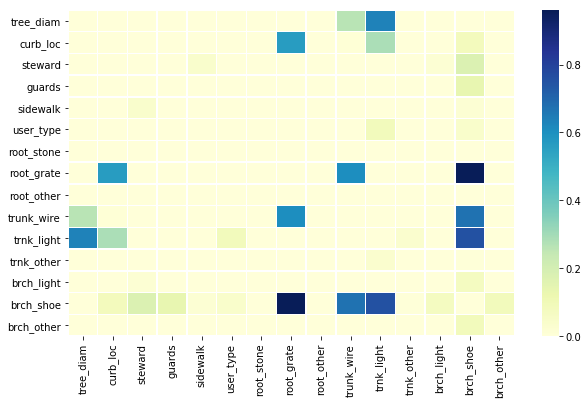

In [53]:
# Apply functions to boroughs dataframes and inspect results
# Remove features that show correlation
# Manhattan
Xman,yman=bor_xy(manh_enc)
pvmat(Xman)

In [54]:
# remove correlated dependent variables
Xman.drop(['sidewalk','root_stone','root_other','trnk_other'],axis=1,inplace=True)

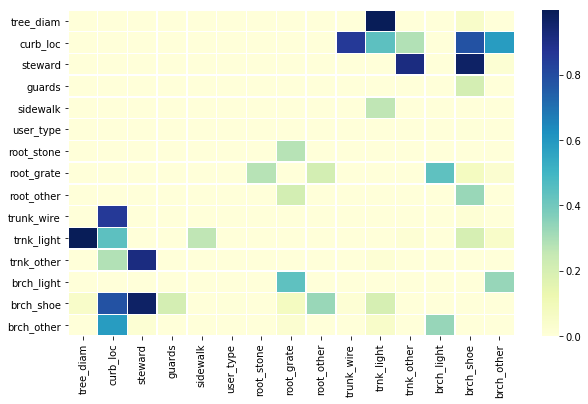

In [55]:
# Repeat for the other boroughs
Xbro,ybro=bor_xy(bronx_enc)
pvmat(Xbro)

In [56]:
# remove correlated dependent variables
Xbro.drop(['user_type'],axis=1,inplace=True)

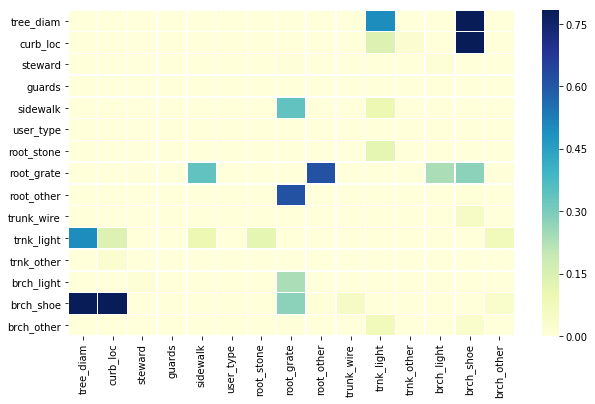

In [57]:
# Queens
Xqu,yqu=bor_xy(queens_enc)
pvmat(Xqu)

In [58]:
# remove correlated dependent variables
Xqu.drop(['steward','guards','user_type','trnk_other'],axis=1,inplace=True)

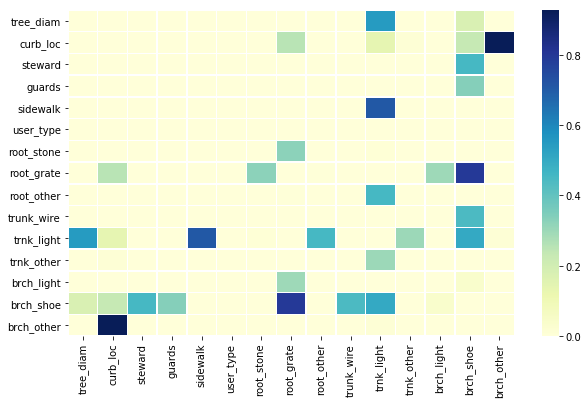

In [59]:
# Brooklin
Xbrk,ybrk=bor_xy(brook_enc)
pvmat(Xbrk)

In [60]:
# remove correlated dependent variables
Xbrk.drop(['user_type'],axis=1,inplace=True)

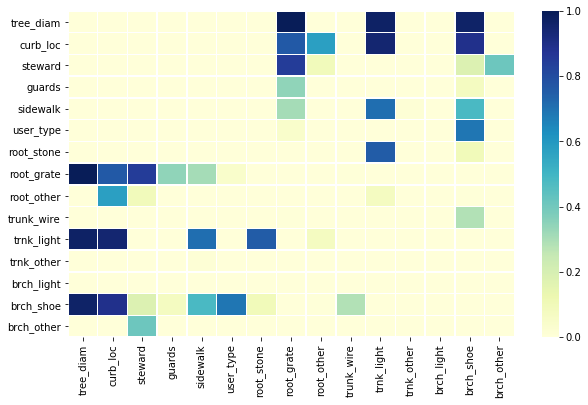

In [61]:
# Staten Island
Xsti,ysti=bor_xy(state_enc)
pvmat(Xsti)

In [62]:
# remove correlated dependent variables
Xsti.drop(['trnk_other','brch_light'],axis=1,inplace=True)

CLASSIFIER

For the classifier model, initially three options are considered and compared: Logistic Regression, KNN and Random Forest. First, out-of-the box models are created and compared, with no cross validation nor tuning. Then cross validation with folds is used, and grid search is implemented to tune hyperparameters. Precision, recall and f1-score are used as metrics. Initially the models are built on Manhattan's data, to get an insight of how they perform.

The next few cells contains functions used to repeat the various tasks on the different datasets, to evaluate metrics and so on.

In [63]:
# Define function that split the data in train/test sets and then uses a sampler to balance (data are unbalanced) 
# For comparison purposes, also the original unbalanced data are used

random=27
tsize=0.2

def split_sample(X,y,sampler):
    
    '''function to split data into training and test set,
    sample only training set'''
       
    Xtr, Xtst, ytr, ytst = train_test_split(X,y,test_size=tsize,random_state=random, stratify=y)
    sampler = sampler(random_state=0)
    Xres, yres = sampler.fit_resample(Xtr, ytr)
    return Xres, Xtst, yres, ytst

# create function to compare classifiers out-of-the-box 
def compare(Xtr,Xtst,ytr,ytst):
    
    ''' compare out-of-the-box classifiers '''
    
    lgreg=LogisticRegression(random_state=random, solver='newton-cg',multi_class='multinomial',max_iter=200)
    lgreg.fit(Xtr,ytr)
    ylrg_pred = lgreg.predict(Xtst)

    knn=KNeighborsClassifier(n_neighbors=6)
    knn.fit(Xtr,ytr)
    yknn_pred = knn.predict(Xtst)

    rf=RandomForestClassifier(n_estimators=100, random_state=random, class_weight='balanced')
    rf.fit(Xtr,ytr)
    yrf_pred = rf.predict(Xtst)

    print('The report for Logistic Regression is: \n', classification_report(ytst, ylrg_pred))
    print('')
    print('The report for KNN is: \n', classification_report(ytst, yknn_pred))
    print('')
    print('The report for Random Forest is: \n', classification_report(ytst, yrf_pred))
    print('')
    print('The confusion matrix for Logistic Regression is: \n', confusion_matrix(ytst, ylrg_pred))
    print('')
    print('The confusion matrix for KNN is: \n', confusion_matrix(ytst, yknn_pred))
    print('')
    print('The confusion matrix for Random Forest is: \n', confusion_matrix(ytst, yrf_pred))
    print('')
    
    
 # the next 2 functions are used to apply a train/test split on a dataset that has been downsampled in a custom way
from sklearn.utils import resample

def custom_downsamp_xy(X,y,random):
    
    '''custom function to downsample majority classes'''
    
    # X,y after train/test split 
    
    df=pd.concat([X,y],axis=1)
        
    print('Classes before downsampling: \n',df['health'].value_counts())
    print('')
    
    # separate classes
    df_fair=df[df['health']==0]
    df_good=df[df['health']==1]
    df_poor=df[df['health']==2]
    
    
    samples=len(df_poor)
    
    # Downsample majority classes
    df_fair_down = resample(df_fair, 
                                 replace=False,    # sample without replacement
                                 n_samples=samples,     # to match minority class
                                 random_state=random) # reproducible results
    
    df_good_down = resample(df_good, 
                                 replace=False,    # sample without replacement
                                 n_samples=samples,     # to match minority class
                                 random_state=random) # reproducible results

    # Combine minority class with downsampled majority classes
    df_down = pd.concat([df_fair_down, df_good_down, df_poor])
 
    # Display new class counts
    print('Classes after downsampling: \n', df_down.health.value_counts())
    print('')
    
    ys=df_down['health']
    df_down.drop(['health'],axis=1,inplace=True)
    Xs=df_down.copy()
    return Xs,ys

def split_sample_custom(X,y,random):
    
    '''function to split data into training and test set,
    sample only training set'''
    
    # stratify keeps the proportions of labels 
    Xtr, Xtst, ytr, ytst = train_test_split(X,y,test_size=tsize,random_state=random, stratify=y)
    Xres, yres = custom_downsamp_xy(Xtr, ytr,random)
    return Xres, Xtst, yres, ytst


In [64]:
def search_tune_clf(clf,Xtr,ytr,Xtst,ytst,grid,scoring):
    
    '''function to perform a grid search on a classifier, based on score,
    fit the classifier, print metrics by class and plot ROC curves on test set'''
    
    # Instantiate the Randomized Search object
    # for scoring of the multiclass classification, None, 'macro', 'weighted' can be chosen 
    clf_cv = RandomizedSearchCV(clf, grid, cv=5, scoring=scoring)
    clf_cv.fit(Xtr,ytr)
    print("Tuned Parameters: {}".format(clf_cv.best_params_)) 
    #print("Best score is {}".format(knn_cv.best_score_))
    print('')
    
    # By default the search returns a classifier already fit with the optimal hyperparameters (refit=True)
    # so there's no need to refit
    ypred = clf_cv.predict(Xtst)
    ypred_prob=clf_cv.predict_proba(Xtst)
    metrics_plot(ytst,ypred,ypred_prob)
    print("The confusion matrix is: \n", confusion_matrix(ytst, ypred))   
    print('')
    
    return (clf_cv)

The following functions print out metrics for each class. Due to the fact the the original dataset is imbalanced, 
using the average metrics might not be the best thing to do; although they are still evaluated. Also, 
for a multiclass classification problem not all the scores are available, only "macro" and "weighted".
The code is taken from sklearn documentation.

In [65]:
from scipy import interp

def class_metrics(ytest,ypred,ypred_pro):
    lb = LabelBinarizer()
    lb.fit(ytest)
    classes=lb.classes_
    ytst_tra = lb.transform(ytest)
    ypred_tra = lb.transform(ypred)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in classes:
        fpr[i], tpr[i], _ = roc_curve(ytst_tra[:, i], ypred_pro[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        print('ROC AUC of class {0:d}: {1:0.4f}'.format(i,roc_auc[i]))
        print('Precision, recall, f1-score of class {0:d}: {1:0.2f} {2:0.2f} {3:0.2f}'.format(i,
            precision_score(ytst_tra[:, i],ypred_tra[:, i]),
            recall_score(ytst_tra[:, i],ypred_tra[:, i]),  
            f1_score(ytst_tra[:, i],ypred_tra[:, i])))

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(ytst_tra.ravel(), ypred_pro.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    
    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in classes]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in classes: mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= len(classes)

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    print('Micro-average ROC AUC {0:0.4f}: '.format(roc_auc["micro"]))
    print('Macro-average ROC AUC {0:0.4f}: '.format(roc_auc["macro"]))
    print('')

def metrics_plot(ytest,ypred,ypred_pro):
    lb = LabelBinarizer()
    lb.fit(ytest)
    classes=lb.classes_
    ytst_tra = lb.transform(ytest)
    ypred_tra = lb.transform(ypred)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in classes:
        fpr[i], tpr[i], _ = roc_curve(ytst_tra[:, i], ypred_pro[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        print('ROC AUC of class {0:d}: {1:0.4f}'.format(i,roc_auc[i]))
        print('Precision, recall, f1-score of class {0:d}: {1:0.2f} {2:0.2f} {3:0.2f}'.format(i,
            precision_score(ytst_tra[:, i],ypred_tra[:, i]),
            recall_score(ytst_tra[:, i],ypred_tra[:, i]),  
            f1_score(ytst_tra[:, i],ypred_tra[:, i])))
        
        plt.plot(fpr[i], tpr[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic of each class')
        plt.legend(loc="lower right")

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(ytst_tra.ravel(), ypred_pro.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    
    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in classes]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in classes: mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= len(classes)

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    print('Micro-average ROC AUC {0:0.4f}: '.format(roc_auc["micro"]))
    print('Macro-average ROC AUC {0:0.4f}: '.format(roc_auc["macro"]))
    print('')
    

As mentioned, initially only Manhattan data are used.
Although it's not good practice, a simple split on imbalanced data, fit on train data and test is run, to get an idea of the scores on the "raw" data.

In [66]:
# create Mahattan train/test split on data as is (unbalanced)
Xtru, Xtstu, ytru, ytstu = train_test_split(Xman,yman,test_size=tsize,random_state=random,stratify=yman)

# compare classifiers
compare(Xtru, Xtstu, ytru, ytstu)

The report for Logistic Regression is: 
               precision    recall  f1-score   support

           0       0.38      0.01      0.02      2291
           1       0.76      1.00      0.86      9471
           2       0.00      0.00      0.00       722

    accuracy                           0.76     12484
   macro avg       0.38      0.34      0.29     12484
weighted avg       0.65      0.76      0.66     12484


The report for KNN is: 
               precision    recall  f1-score   support

           0       0.24      0.16      0.19      2291
           1       0.77      0.89      0.83      9471
           2       0.21      0.02      0.03       722

    accuracy                           0.71     12484
   macro avg       0.41      0.36      0.35     12484
weighted avg       0.64      0.71      0.66     12484


The report for Random Forest is: 
               precision    recall  f1-score   support

           0       0.23      0.26      0.24      2291
           1       0.81   

As expected, on the imbalanced dataset and with no cross-validation, the algorithms have highest scores on the majority class. Logistic Regression and KNN aren't able to predict either one of both the minority classes, while Random Forest with the "balance" option gives better results for such classes. But it's worse for the class with the majority of data.

Next, sampling is used to provide a balanced dataset to the algorithms and cross-validation is applied. Different samplers are used. Also, a loop is written to go through the folds and print the individual scores of the classes. cross_val_score can be used instead to have a concise form and print of the score.

In [67]:
Xtr_sam, Xtst_sam, ytr_sam, ytst_sam = split_sample(Xman,yman,SMOTEENN)

# StratifiedKFold create folds with data proportional to the original
skf= StratifiedKFold(n_splits=5, shuffle=True, random_state=random)

for tr_ind, tst_ind in skf.split(Xtr_sam, ytr_sam):
    Xtr, Xtst = Xtr_sam[tr_ind], Xtr_sam[tst_ind]
    ytr, ytst = ytr_sam[tr_ind], ytr_sam[tst_ind]
    rf=RandomForestClassifier(n_estimators=100, random_state=random, class_weight='balanced')
    rf.fit(Xtr,ytr)
    ypred=rf.predict(Xtst)
    ypred_prob=rf.predict_proba(Xtst)
    class_metrics(ytst,ypred,ypred_prob)

ROC AUC of class 0: 0.9999
Precision, recall, f1-score of class 0: 0.99 1.00 0.99
ROC AUC of class 1: 0.9999
Precision, recall, f1-score of class 1: 1.00 0.99 0.99
ROC AUC of class 2: 0.9993
Precision, recall, f1-score of class 2: 1.00 1.00 1.00
Micro-average ROC AUC 0.9997: 
Macro-average ROC AUC 0.9997: 

ROC AUC of class 0: 0.9997
Precision, recall, f1-score of class 0: 0.99 0.99 0.99
ROC AUC of class 1: 0.9997
Precision, recall, f1-score of class 1: 0.99 0.99 0.99
ROC AUC of class 2: 1.0000
Precision, recall, f1-score of class 2: 1.00 1.00 1.00
Micro-average ROC AUC 0.9998: 
Macro-average ROC AUC 0.9998: 

ROC AUC of class 0: 0.9993
Precision, recall, f1-score of class 0: 1.00 1.00 1.00
ROC AUC of class 1: 0.9996
Precision, recall, f1-score of class 1: 1.00 1.00 1.00
ROC AUC of class 2: 1.0000
Precision, recall, f1-score of class 2: 1.00 1.00 1.00
Micro-average ROC AUC 0.9997: 
Macro-average ROC AUC 0.9997: 

ROC AUC of class 0: 1.0000
Precision, recall, f1-score of class 0: 0.99 0

Cross-validation on five folds gives too good results, the model is probably overfitting. It is verified aginst the hold-out set.

In [68]:
rf=RandomForestClassifier(n_estimators=100, random_state=random, class_weight='balanced')
rf.fit(Xtr_sam, ytr_sam)
ypred_rf=rf.predict(Xtst_sam)
ypred_prob_rf=rf.predict_proba(Xtst_sam)
class_metrics(ytst_sam,ypred_rf,ypred_prob_rf)

ROC AUC of class 0: 0.5596
Precision, recall, f1-score of class 0: 0.23 0.33 0.27
ROC AUC of class 1: 0.5791
Precision, recall, f1-score of class 1: 0.79 0.64 0.71
ROC AUC of class 2: 0.5408
Precision, recall, f1-score of class 2: 0.08 0.17 0.11
Micro-average ROC AUC 0.7121: 
Macro-average ROC AUC 0.5598: 



The results on the test set are much worse then cross-validation.

In [69]:
# Use different sampler, a custom one.
Xtr_cus, Xtst_cus, ytr_cus, ytst_cus=split_sample_custom(Xman,yman,random)

skf_cus= StratifiedKFold(n_splits=5, shuffle=True, random_state=random)

for tr_ind, tst_ind in skf_cus.split(Xtr_cus, ytr_cus):
    Xtr, Xtst = Xtr_cus.iloc[tr_ind], Xtr_cus.iloc[tst_ind]
    ytr, ytst = ytr_cus.iloc[tr_ind], ytr_cus.iloc[tst_ind]
    rf_cus=RandomForestClassifier(n_estimators=100, random_state=random, class_weight='balanced')
    rf_cus.fit(Xtr,ytr)
    ypred_cus=rf_cus.predict(Xtst)
    ypred_prob_cus=rf_cus.predict_proba(Xtst)
    class_metrics(ytst,ypred_cus,ypred_prob_cus)

rf_cus=RandomForestClassifier(n_estimators=100, random_state=random, class_weight='balanced')
rf_cus.fit(Xtr_cus, ytr_cus)
ypred_rf=rf_cus.predict(Xtst_cus)
ypred_prob_rf=rf_cus.predict_proba(Xtst_cus)
print('Results on test set')
class_metrics(ytst_cus,ypred_rf,ypred_prob_rf)    

Classes before downsampling: 
 1    37880
0     9166
2     2887
Name: health, dtype: int64

Classes after downsampling: 
 2    2887
1    2887
0    2887
Name: health, dtype: int64

ROC AUC of class 0: 0.5392
Precision, recall, f1-score of class 0: 0.37 0.33 0.35
ROC AUC of class 1: 0.6346
Precision, recall, f1-score of class 1: 0.45 0.46 0.45
ROC AUC of class 2: 0.6354
Precision, recall, f1-score of class 2: 0.45 0.49 0.47
Micro-average ROC AUC 0.6048: 
Macro-average ROC AUC 0.6032: 

ROC AUC of class 0: 0.5215
Precision, recall, f1-score of class 0: 0.34 0.31 0.32
ROC AUC of class 1: 0.6014
Precision, recall, f1-score of class 1: 0.40 0.44 0.42
ROC AUC of class 2: 0.6339
Precision, recall, f1-score of class 2: 0.44 0.44 0.44
Micro-average ROC AUC 0.5876: 
Macro-average ROC AUC 0.5857: 

ROC AUC of class 0: 0.5444
Precision, recall, f1-score of class 0: 0.37 0.30 0.33
ROC AUC of class 1: 0.6213
Precision, recall, f1-score of class 1: 0.43 0.46 0.44
ROC AUC of class 2: 0.6193
Precision, 

The results with the custom sampler are worse in cross-validation, with respect to SMOTEENN sampler. For the test-set, recall of the third (minority class) got better.

In [70]:
# Try one last sampler available from package
Xtr_enn, Xtst_enn, ytr_enn, ytst_enn = train_test_split(Xman,yman,test_size=tsize,random_state=random, stratify=yman)

enn = EditedNearestNeighbours(n_neighbors=3,sampling_strategy='majority',random_state=random)
Xres, yres = enn.fit_resample(Xtr_enn, ytr_enn)

skf_enn= StratifiedKFold(n_splits=5, shuffle=True, random_state=random)

for tr_ind, tst_ind in skf_enn.split(Xres, yres):
    Xtr, Xtst = Xres[tr_ind], Xres[tst_ind]
    ytr, ytst = yres[tr_ind], yres[tst_ind]
    rf_enn=RandomForestClassifier(n_estimators=100, random_state=random, class_weight='balanced')
    rf_enn.fit(Xtr,ytr)
    ypred_enn=rf_enn.predict(Xtst)
    ypred_prob_enn=rf_enn.predict_proba(Xtst)
    class_metrics(ytst,ypred_enn,ypred_prob_enn)

rf_enn=RandomForestClassifier(n_estimators=100, random_state=random, class_weight='balanced')
rf_enn.fit(Xres,yres)
ypred_rf=rf_enn.predict(Xtst_enn)
ypred_prob_rf=rf_enn.predict_proba(Xtst_enn)
print('Results on test set')
class_metrics(ytst_enn,ypred_rf,ypred_prob_rf)    

ROC AUC of class 0: 0.7594
Precision, recall, f1-score of class 0: 0.73 0.38 0.50
ROC AUC of class 1: 0.8388
Precision, recall, f1-score of class 1: 0.81 0.91 0.86
ROC AUC of class 2: 0.7401
Precision, recall, f1-score of class 2: 0.24 0.40 0.30
Micro-average ROC AUC 0.8592: 
Macro-average ROC AUC 0.7794: 

ROC AUC of class 0: 0.7619
Precision, recall, f1-score of class 0: 0.71 0.37 0.49
ROC AUC of class 1: 0.8353
Precision, recall, f1-score of class 1: 0.80 0.90 0.85
ROC AUC of class 2: 0.7309
Precision, recall, f1-score of class 2: 0.22 0.38 0.28
Micro-average ROC AUC 0.8558: 
Macro-average ROC AUC 0.7761: 

ROC AUC of class 0: 0.7547
Precision, recall, f1-score of class 0: 0.71 0.35 0.47
ROC AUC of class 1: 0.8414
Precision, recall, f1-score of class 1: 0.81 0.92 0.86
ROC AUC of class 2: 0.7380
Precision, recall, f1-score of class 2: 0.22 0.37 0.28
Micro-average ROC AUC 0.8568: 
Macro-average ROC AUC 0.7781: 

ROC AUC of class 0: 0.7562
Precision, recall, f1-score of class 0: 0.70 0

With this sampler and with respect to the custom one, results on cross_validation are better for the first and second class, worse for the third one. On the test set, the results are similar.

Another option to consider when dealing with imbalanced data is to change the probability thresholds. 

In [71]:
def yadj(yprob,t):
    return [1 if y>=t else 0 for y in yprob]

def auc_vs_threshold(ytest,ypred,ypred_pro,t):
    lb = LabelBinarizer()
    lb.fit(ytest)
    classes=lb.classes_
    ytst_tra = lb.transform(ytest)
    ypred_tra = lb.transform(ypred)
       
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in classes:
        ypred_prob_adj=yadj(ypred_pro[:, i],t)
        fpr[i], tpr[i], _ = roc_curve(ytst_tra[:, i], ypred_prob_adj)
        roc_auc[i] = auc(fpr[i], tpr[i])
        print('ROC AUC of class {0:d}: {1:0.4f}'.format(i,roc_auc[i]))
        #return roc_auc

In [72]:
tlist=[0.1,0.2,0.3,0.4,0.5,0.6,.7,.8,.9]
for t in tlist:
    auc_vs_threshold(ytst_enn,ypred_rf,ypred_prob_rf,t)
    print('')

ROC AUC of class 0: 0.5088
ROC AUC of class 1: 0.5355
ROC AUC of class 2: 0.5459

ROC AUC of class 0: 0.5229
ROC AUC of class 1: 0.5391
ROC AUC of class 2: 0.5648

ROC AUC of class 0: 0.5274
ROC AUC of class 1: 0.5380
ROC AUC of class 2: 0.5638

ROC AUC of class 0: 0.5129
ROC AUC of class 1: 0.5494
ROC AUC of class 2: 0.5553

ROC AUC of class 0: 0.5081
ROC AUC of class 1: 0.5580
ROC AUC of class 2: 0.5551

ROC AUC of class 0: 0.5055
ROC AUC of class 1: 0.5497
ROC AUC of class 2: 0.5415

ROC AUC of class 0: 0.5073
ROC AUC of class 1: 0.5269
ROC AUC of class 2: 0.5215

ROC AUC of class 0: 0.5073
ROC AUC of class 1: 0.5182
ROC AUC of class 2: 0.5053

ROC AUC of class 0: 0.5048
ROC AUC of class 1: 0.5104
ROC AUC of class 2: 0.5040



There's no significant better results with respect to the default setting.

The same steps are repeated using KNN and the splits with the last sampler.

In [73]:
skfk= StratifiedKFold(n_splits=5, shuffle=True, random_state=random)

for tr_ind, tst_ind in skfk.split(Xres, yres):
    Xtr, Xtst = Xres[tr_ind], Xres[tst_ind]
    ytr, ytst = yres[tr_ind], yres[tst_ind]
    knn=KNeighborsClassifier(n_neighbors=6)
    knn.fit(Xtr,ytr)
    ypredk=knn.predict(Xtst)
    ypredk_prob=knn.predict_proba(Xtst)
    class_metrics(ytst,ypredk,ypredk_prob)

print('')    
knn=KNeighborsClassifier(n_neighbors=6)
knn.fit(Xres,yres)
ypredk_new=knn.predict(Xtst_enn)
ypredk_prob_new=knn.predict_proba(Xtst_enn)
print('Results on test set')
class_metrics(ytst_enn,ypredk_new,ypredk_prob_new)    

ROC AUC of class 0: 0.7282
Precision, recall, f1-score of class 0: 0.55 0.62 0.58
ROC AUC of class 1: 0.7881
Precision, recall, f1-score of class 1: 0.80 0.86 0.83
ROC AUC of class 2: 0.5856
Precision, recall, f1-score of class 2: 0.46 0.02 0.04
Micro-average ROC AUC 0.8192: 
Macro-average ROC AUC 0.7006: 

ROC AUC of class 0: 0.7354
Precision, recall, f1-score of class 0: 0.55 0.63 0.59
ROC AUC of class 1: 0.7846
Precision, recall, f1-score of class 1: 0.79 0.85 0.82
ROC AUC of class 2: 0.5827
Precision, recall, f1-score of class 2: 0.34 0.02 0.03
Micro-average ROC AUC 0.8195: 
Macro-average ROC AUC 0.7009: 

ROC AUC of class 0: 0.7240
Precision, recall, f1-score of class 0: 0.52 0.64 0.58
ROC AUC of class 1: 0.7953
Precision, recall, f1-score of class 1: 0.80 0.82 0.81
ROC AUC of class 2: 0.5842
Precision, recall, f1-score of class 2: 0.38 0.03 0.06
Micro-average ROC AUC 0.8183: 
Macro-average ROC AUC 0.7011: 

ROC AUC of class 0: 0.7307
Precision, recall, f1-score of class 0: 0.52 0

With respect to Random Forest, KNN gives worst results on cross-validation. On test, one minority class prediction is better, one is worse.

With the results seen so far, feature analysis is revised. Although features have been selected previously, additional tools are used to gain more insight. First, PCA is used to see how many features explain much of the data variance. Then various feature selection tools are considered.

Text(0, 0.5, 'variance')

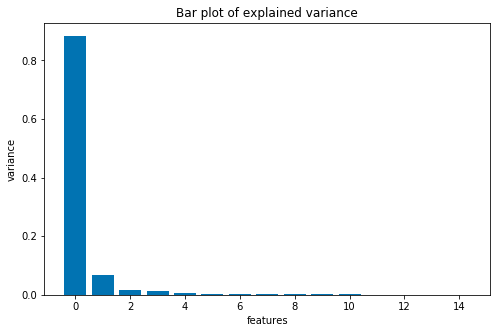

In [74]:
# For the features analysis the original dataset is used (before dropping the feautures 
# from the custom chi-square test)
X1,y1=bor_xy(manh_enc)

pca = PCA()
pca.fit(X1)

features_pca=range(pca.n_components_)

plt.figure(figsize=(8,5))
plt.bar(features_pca,pca.explained_variance_ratio_)
plt.title('Bar plot of explained variance')
plt.xlabel('features')
plt.ylabel('variance')

PCA analysis shows that one feature accounts for most of the variance. For feature selection, a number of 2 is then chosen.

In [75]:
# Feature extraction
test = SelectKBest(score_func=chi2, k=2)
fit = test.fit(X1, y1)

# Summarize scores
np.set_printoptions(precision=3)
#print(fit.scores_)

features = fit.transform(X1)
# print top 2 features
#print(fit.get_support())
top2=X1.columns.values[fit.get_support()==True]
print('Top 2 features according to SelectKBest:')
for f in top2: print(f)
print('')

from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X1s=scaler.fit_transform(X1)
lg = LogisticRegression(solver='newton-cg',multi_class='ovr')
rfe = RFE(lg, 2)
fit_lg = rfe.fit(X1s, y1)
#print("Num Features: %d" % fit.n_features_)
#print("Selected Features: %s" % fit.support_)
#print("Feature Ranking: %s" % fit.ranking_)
print('Top 2 features according to RFE on logistic regression:')
top2_lg=X1.columns.values[fit_lg.support_==True]
for f in top2_lg: print(f)
print('')

rfor=RandomForestClassifier(n_estimators=10,random_state=random)
rfe_rf = RFE(rfor, 2)
fit_rf = rfe_rf.fit(X1, y1)
print('Top 2 features according to RFE on Random Forest:')
top2_rf=X1.columns.values[fit_rf.support_==True]
for f in top2_rf: print(f)
print('')
    
rfor.fit(X1, y1)
#print(model3.feature_importances_)
feature_importances1 = pd.DataFrame(rfor.feature_importances_, index = X1.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
print('Features importances of Random Forest:')
feature_importances1    


Top 2 features according to SelectKBest:
tree_diam
brch_other

Top 2 features according to RFE on logistic regression:
tree_diam
brch_other

Top 2 features according to RFE on Random Forest:
tree_diam
brch_other

Features importances of Random Forest:


,importance
tree_diam,0.429619
guards,0.089768
brch_other,0.088174
steward,0.085363
user_type,0.067831
trnk_other,0.052262
sidewalk,0.042789
root_stone,0.034630
root_other,0.028023
root_grate,0.020790


With the results of the feature analysis, new models are trained that include less features and compared to a model with all features. Also, a grid search is done to tune hyperparameters.

In [76]:
# define Random Forest grid
rf_grid = {
    'min_samples_split': [3, 5, 10], 
    'n_estimators' : [5, 10, 20, 50],
    'max_depth': [3, 5, 15],
    'max_features': [0.2, 0.3,0.5, 1],
    'criterion': ['gini','entropy'],
}

# define KNN grid
n_space=np.arange(1, 50)
alg_space=['ball_tree','kd_tree','brute']
p_space=[1,2]
weights=['uniform','distance']
k_grid={'n_neighbors': n_space,'p': p_space,'algorithm': alg_space}

scoring='f1_macro'



In [77]:
# define a new split that keeps only 2 features
# X1, y1 are Manhattan data that include all features.
# Here only 2 are selected.
Xtr2, Xtst2, ytr2, ytst2 = train_test_split(X1[['tree_diam','brch_other']],y1,test_size=tsize,random_state=random, 
                                            stratify=y1)
enn = EditedNearestNeighbours(n_neighbors=3,sampling_strategy='majority',random_state=random)
Xres2, yres2 = enn.fit_resample(Xtr2, ytr2)

Tuned Parameters: {'n_estimators': 10, 'min_samples_split': 10, 'max_features': 0.2, 'max_depth': 15, 'criterion': 'entropy'}

ROC AUC of class 0: 0.5345
Precision, recall, f1-score of class 0: 0.17 0.08 0.11
ROC AUC of class 1: 0.5788
Precision, recall, f1-score of class 1: 0.81 0.57 0.67
ROC AUC of class 2: 0.6290
Precision, recall, f1-score of class 2: 0.08 0.56 0.15
Micro-average ROC AUC 0.5204: 
Macro-average ROC AUC 0.5808: 

The confusion matrix is: 
 [[ 186 1015 1090]
 [ 873 5369 3229]
 [  47  274  401]]



RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight='balanced',
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_job

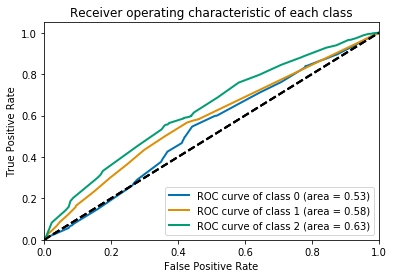

In [78]:
# perform grid search and tune parameters for RF
# scoring function is f1
rf=RandomForestClassifier(random_state=random,class_weight='balanced')
search_tune_clf(rf,Xres2,yres2,Xtst2,ytst2,rf_grid,scoring)

c:\users\silvia\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\silvia\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\silvia\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\silvia\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predic

Tuned Parameters: {'p': 2, 'n_neighbors': 13, 'algorithm': 'brute'}

ROC AUC of class 0: 0.5450
Precision, recall, f1-score of class 0: 0.21 0.47 0.29
ROC AUC of class 1: 0.5688
Precision, recall, f1-score of class 1: 0.80 0.58 0.67
ROC AUC of class 2: 0.6107
Precision, recall, f1-score of class 2: 0.09 0.08 0.09
Micro-average ROC AUC 0.6145: 
Macro-average ROC AUC 0.5748: 

The confusion matrix is: 
 [[1070 1066  155]
 [3541 5469  461]
 [ 379  283   60]]



RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=KNeighborsClassifier(algorithm='auto',
                                                  leaf_size=30,
                                                  metric='minkowski',
                                                  metric_params=None,
                                                  n_jobs=None, n_neighbors=5,
                                                  p=2, weights='uniform'),
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distributions={'algorithm': ['ball_tree', 'kd_tree',
                                                      'brute'],
                                        'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
                                        'p': [

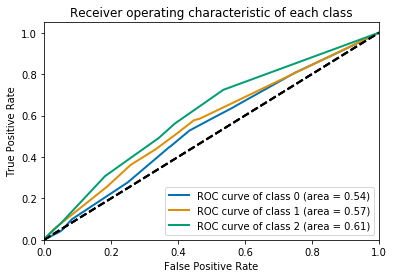

In [79]:
# perform grid search and tune parameters for KNN
# scoring function is f1
knn=KNeighborsClassifier()
search_tune_clf(knn,Xres2,yres2,Xtst2,ytst2,k_grid,scoring)

Using only these 2 features didn't lead to much different or better results. It's not shown here, but depending on the sampler used, the recall of one of the minority class would get better, while the other would get worse. Since the split with SMOTEENN gives worse results on recall of the "poor" class, the other sampler is preferred.

One more thing to try is still considering 2 features, but the second one being the "problems" column, which is believed to summarize the others and has been initially dropped.

In [80]:
# define a new function that keeps the "problems" column and encodes the values
def bor_xy_prob(df):
    
    ''' function to create X,y for each borough to use in model'''
    
    X=df.copy()
    X.drop(['created_at','species','borough','borocode','nta_name','latitude','longitude'],
           axis=1,inplace=True)
    y=X['health']
    X['prob_enc']=label_enc(X.problems)
    X.drop(['health','problems'],axis=1,inplace=True)
    return X,y


In [81]:
# repeat the same procedure, i.e. create a new split using only tree diameter and problems, 
#train classifiers and tune paramters
X3,y3=bor_xy_prob(manh_enc)

Xtr3, Xtst3, ytr3, ytst3 = train_test_split(X3[['tree_diam','prob_enc']],y3,test_size=tsize,random_state=random, 
                                            stratify=y3)
enn = EditedNearestNeighbours(n_neighbors=3,sampling_strategy='majority',random_state=random)
Xres3, yres3 = enn.fit_resample(Xtr3, ytr3)

Tuned Parameters: {'n_estimators': 10, 'min_samples_split': 10, 'max_features': 0.5, 'max_depth': 15, 'criterion': 'gini'}

ROC AUC of class 0: 0.5415
Precision, recall, f1-score of class 0: 0.20 0.32 0.24
ROC AUC of class 1: 0.5693
Precision, recall, f1-score of class 1: 0.81 0.53 0.64
ROC AUC of class 2: 0.6057
Precision, recall, f1-score of class 2: 0.09 0.32 0.14
Micro-average ROC AUC 0.5132: 
Macro-average ROC AUC 0.5722: 

The confusion matrix is: 
 [[ 736  936  619]
 [2796 5018 1657]
 [ 217  277  228]]



RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight='balanced',
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_job

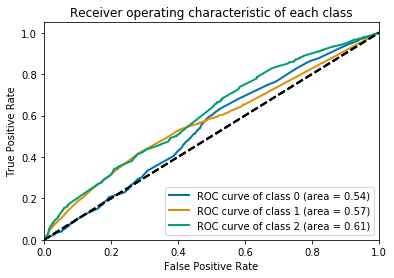

In [82]:
# perform grid search and tune parameters for RF
# scoring function is f1
rf=RandomForestClassifier(random_state=random,class_weight='balanced')
search_tune_clf(rf,Xres3,yres3,Xtst3,ytst3,rf_grid,scoring)

Tuned Parameters: {'p': 1, 'n_neighbors': 5, 'algorithm': 'brute'}

ROC AUC of class 0: 0.5434
Precision, recall, f1-score of class 0: 0.21 0.51 0.30
ROC AUC of class 1: 0.5575
Precision, recall, f1-score of class 1: 0.80 0.55 0.65
ROC AUC of class 2: 0.5571
Precision, recall, f1-score of class 2: 0.09 0.04 0.06
Micro-average ROC AUC 0.6204: 
Macro-average ROC AUC 0.5527: 

The confusion matrix is: 
 [[1169 1034   88]
 [4002 5254  215]
 [ 378  313   31]]



RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=KNeighborsClassifier(algorithm='auto',
                                                  leaf_size=30,
                                                  metric='minkowski',
                                                  metric_params=None,
                                                  n_jobs=None, n_neighbors=5,
                                                  p=2, weights='uniform'),
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distributions={'algorithm': ['ball_tree', 'kd_tree',
                                                      'brute'],
                                        'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
                                        'p': [

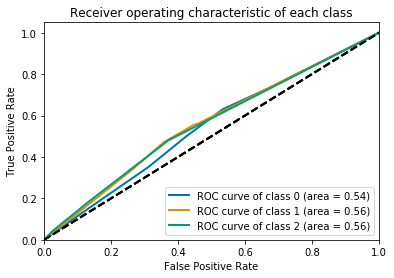

In [83]:
knn=KNeighborsClassifier()
search_tune_clf(knn,Xres3,yres3,Xtst3,ytst3,k_grid,scoring)

Using the tree diameter and the "problems" column didn't lead to much better results. 
From now on, the ENN sampler is applied and all the features, including latitude and longitude, are used.

In [84]:
# for this function all encoded features are included, together with latitude and longitude
# use all manhattan data
def bor_xy_loc(df):
    
    ''' function to create X,y for each borough to use in model'''
    
    X=df.copy()
    X.drop(['created_at','species','borough','borocode','nta_name'],
           axis=1,inplace=True)
    y=X['health']
    X['prob_enc']=label_enc(X.problems)
    X.drop(['health','problems'],axis=1,inplace=True)
    return X,y


In [85]:
Xm,ym=bor_xy_loc(manh_enc)
Xtrm, Xtstm, ytrm, ytstm = train_test_split(Xm,ym,test_size=tsize,random_state=random, stratify=ym)
enn = EditedNearestNeighbours(n_neighbors=3,sampling_strategy='majority',random_state=random)
Xmres, ymres = enn.fit_resample(Xtrm, ytrm)

Tuned Parameters: {'n_estimators': 20, 'min_samples_split': 3, 'max_features': 0.5, 'max_depth': 15, 'criterion': 'gini'}

ROC AUC of class 0: 0.6626
Precision, recall, f1-score of class 0: 0.29 0.47 0.36
ROC AUC of class 1: 0.7063
Precision, recall, f1-score of class 1: 0.85 0.68 0.76
ROC AUC of class 2: 0.7030
Precision, recall, f1-score of class 2: 0.17 0.26 0.20
Micro-average ROC AUC 0.7747: 
Macro-average ROC AUC 0.6907: 

The confusion matrix is: 
 [[1072  930  289]
 [2335 6477  659]
 [ 278  255  189]]



RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight='balanced',
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_job

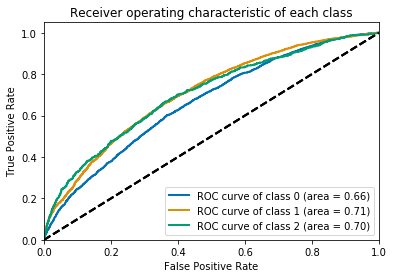

In [86]:
rf=RandomForestClassifier(random_state=random, class_weight='balanced')
search_tune_clf(rf,Xmres,ymres,Xtstm,ytstm,rf_grid,scoring)

Tuned Parameters: {'p': 1, 'n_neighbors': 2, 'algorithm': 'ball_tree'}

ROC AUC of class 0: 0.5972
Precision, recall, f1-score of class 0: 0.23 0.65 0.34
ROC AUC of class 1: 0.6376
Precision, recall, f1-score of class 1: 0.84 0.51 0.64
ROC AUC of class 2: 0.5934
Precision, recall, f1-score of class 2: 0.18 0.08 0.11
Micro-average ROC AUC 0.6914: 
Macro-average ROC AUC 0.6094: 

The confusion matrix is: 
 [[1496  708   87]
 [4437 4858  176]
 [ 479  186   57]]



RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=KNeighborsClassifier(algorithm='auto',
                                                  leaf_size=30,
                                                  metric='minkowski',
                                                  metric_params=None,
                                                  n_jobs=None, n_neighbors=5,
                                                  p=2, weights='uniform'),
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distributions={'algorithm': ['ball_tree', 'kd_tree',
                                                      'brute'],
                                        'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
                                        'p': [

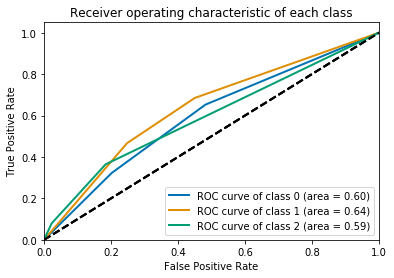

In [87]:
knn=KNeighborsClassifier()
search_tune_clf(knn,Xmres,ymres,Xtstm,ytstm,k_grid,scoring)

At this point, the same procedure is applied to the other boroughs. All encoded features, plus latitude and longitude are used. The scoring function is still f1. Also, for comparison a model is trained and tested with all the data of all the boroughs, with the borough information included as one of the features. Only a Random Forest classifier is built at this point, since from the above results it looks like it gives better results.

In [88]:
def model_rf(df,random,scoring):
    X,y=bor_xy_loc(df)
    Xtr, Xtst, ytr, ytst = train_test_split(X,y,test_size=tsize,random_state=random, stratify=y)
    enn = EditedNearestNeighbours(n_neighbors=3,sampling_strategy='majority',random_state=random)
    Xres, yres = enn.fit_resample(Xtr, ytr)
    rf=RandomForestClassifier(random_state=random, class_weight='balanced')
    search_tune_clf(rf,Xres,yres,Xtst,ytst,rf_grid,scoring)

Brooklyn model results
Tuned Parameters: {'n_estimators': 10, 'min_samples_split': 3, 'max_features': 1, 'max_depth': 15, 'criterion': 'gini'}

ROC AUC of class 0: 0.6346
Precision, recall, f1-score of class 0: 0.24 0.34 0.28
ROC AUC of class 1: 0.6725
Precision, recall, f1-score of class 1: 0.88 0.62 0.73
ROC AUC of class 2: 0.6903
Precision, recall, f1-score of class 2: 0.07 0.44 0.13
Micro-average ROC AUC 0.7427: 
Macro-average ROC AUC 0.6658: 

The confusion matrix is: 
 [[ 1698  1917  1399]
 [ 4918 17159  5560]
 [  341   386   564]]



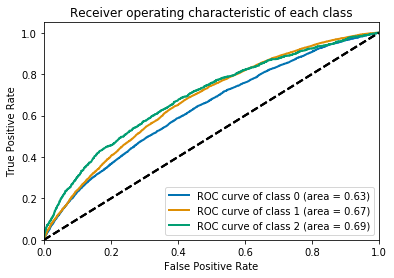

In [89]:
print('Brooklyn model results')
model_rf(brook_enc,random,scoring)

Queens model results
Tuned Parameters: {'n_estimators': 20, 'min_samples_split': 5, 'max_features': 0.5, 'max_depth': 15, 'criterion': 'entropy'}

ROC AUC of class 0: 0.6660
Precision, recall, f1-score of class 0: 0.25 0.43 0.31
ROC AUC of class 1: 0.7064
Precision, recall, f1-score of class 1: 0.89 0.70 0.78
ROC AUC of class 2: 0.7197
Precision, recall, f1-score of class 2: 0.12 0.33 0.18
Micro-average ROC AUC 0.7949: 
Macro-average ROC AUC 0.6974: 

The confusion matrix is: 
 [[ 2936  2885  1087]
 [ 8195 27132  3471]
 [  631   633   619]]



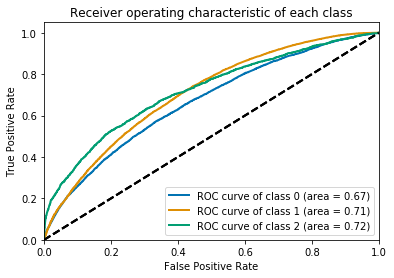

In [90]:
print('Queens model results')
model_rf(queens_enc,random,scoring)

Staten Island model results
Tuned Parameters: {'n_estimators': 5, 'min_samples_split': 5, 'max_features': 0.5, 'max_depth': 15, 'criterion': 'entropy'}

ROC AUC of class 0: 0.7218
Precision, recall, f1-score of class 0: 0.27 0.53 0.36
ROC AUC of class 1: 0.7627
Precision, recall, f1-score of class 1: 0.91 0.69 0.78
ROC AUC of class 2: 0.7152
Precision, recall, f1-score of class 2: 0.14 0.36 0.20
Micro-average ROC AUC 0.8214: 
Macro-average ROC AUC 0.7332: 

The confusion matrix is: 
 [[ 1535   852   520]
 [ 3857 11337  1333]
 [  290   251   306]]



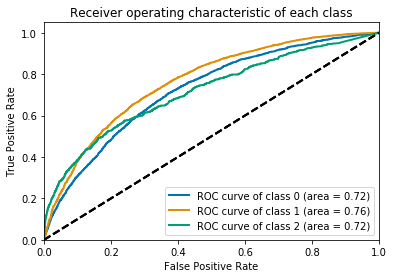

In [91]:
print('Staten Island model results')
model_rf(state_enc,random,scoring)

Bronx model results
Tuned Parameters: {'n_estimators': 50, 'min_samples_split': 3, 'max_features': 0.5, 'max_depth': 15, 'criterion': 'gini'}

ROC AUC of class 0: 0.6783
Precision, recall, f1-score of class 0: 0.26 0.40 0.32
ROC AUC of class 1: 0.7248
Precision, recall, f1-score of class 1: 0.89 0.80 0.84
ROC AUC of class 2: 0.7068
Precision, recall, f1-score of class 2: 0.20 0.25 0.22
Micro-average ROC AUC 0.8555: 
Macro-average ROC AUC 0.7033: 

The confusion matrix is: 
 [[  876  1102   199]
 [ 2298 10594   427]
 [  210   257   152]]



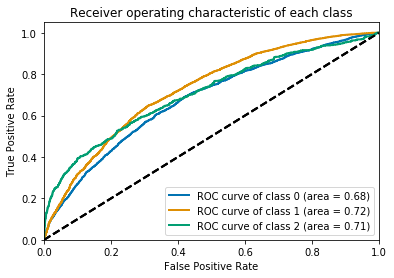

In [92]:
print('Bronx model results')
model_rf(bronx_enc,random,scoring)

In [93]:
# for the classifier that uses all data, the borough information (code) is included
def allbor_xy_loc(df):
    
    ''' function to create X,y for all data to use in model'''
    
    X=df.copy()
    X.drop(['created_at','species','borough','nta_name'],
           axis=1,inplace=True)
    y=X['health']
    X['prob_enc']=label_enc(X.problems)
    X.drop(['health','problems'],axis=1,inplace=True)
    return X,y

In [94]:
Xall,yall=allbor_xy_loc(df_tree_enc)

Whole NYC model results
Tuned Parameters: {'n_estimators': 50, 'min_samples_split': 5, 'max_features': 0.5, 'max_depth': 15, 'criterion': 'entropy'}

ROC AUC of class 0: 0.6652
Precision, recall, f1-score of class 0: 0.24 0.41 0.30
ROC AUC of class 1: 0.6999
Precision, recall, f1-score of class 1: 0.88 0.67 0.76
ROC AUC of class 2: 0.7212
Precision, recall, f1-score of class 2: 0.11 0.37 0.17
Micro-average ROC AUC 0.7652: 
Macro-average ROC AUC 0.6955: 

The confusion matrix is: 
 [[ 7875  7746  3676]
 [22857 70835 12058]
 [ 1613  1773  1976]]



RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight='balanced',
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_job

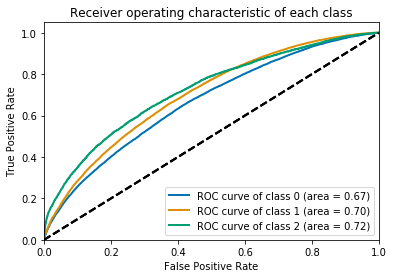

In [95]:
print('Whole NYC model results')
Xtr, Xtst, ytr, ytst = train_test_split(Xall,yall,test_size=tsize,random_state=random, stratify=yall)
enn = EditedNearestNeighbours(n_neighbors=3,sampling_strategy='majority',random_state=random)
Xres, yres = enn.fit_resample(Xtr, ytr)
rf=RandomForestClassifier(random_state=random, class_weight='balanced')
search_tune_clf(rf,Xres,yres,Xtst,ytst,rf_grid,scoring)

To try improve the model, one possibility is to further analyse the features, to understande what affects the fair and poor health classes. Another option is to combine these two classes and make it a binary classification problem. Or re-formulate the problem completely, for example as an anomaly detections problem.